## Microsoft-Movie-Studio-Box-Office-Analysis


**Author**:[Oscar Mulei](mailto:omulei@gmail.com)
***

## Overview
This project provides a comprehensive analysis of box office performance for movies. The goal is to offer valuable insights to Microsoft's newly established movie studio. The analysis covers various aspects of movies, such as genres, ratings, budgets, and release dates, to uncover the factors that contribute to a successful box office performance.
***

## Business Problem
***
Microsoft, recognizing the success of other big companies in creating original video content, is eager to enter the movie industry. However, despite their eagerness, they lack experience in movie creation. The challenge lies in understanding the current movie landscape and identifying the types of films that perform well at the box office. This project aims to explore these aspects, and its findings will guide the decision-making process for Microsoft's new movie studio, helping to decide what type of films to create.

***

## Data
The project leverages several datasets, providing comprehensive movie-related information. Each movie has a unique ID associated with its [intake](link-to-intake-dataset) and [outcome](link-to-outcome-dataset) data. The datasets offer valuable data points, such as movie titles, genres, average ratings, domestic and foreign gross revenues, and release years.

Given the business problem, we recognize the need to incorporate additional data to provide more comprehensive insights. This includes information on movie genre, budget and box office revenue, director and cast, runtime, and regional and language specifics. However, our current dataset includes the movie name, release year, and IMDB rating. Future enhancements of this analysis may include these additional data points.
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import ast

%matplotlib inline

In [2]:
# !ls

In [3]:
# Read the genre CSV into a DataFrame
genres_df = pd.read_csv('genres.csv')

# Create a dictionary mapping genre IDs to names
genre_dict = genres_df.set_index('id')['name'].to_dict()

# Define a function to map IDs to names
def map_ids_to_names(ids):
    return [genre_dict.get(id, id) for id in ids]

In [4]:
movie_gross = pd.read_csv('bom.movie_gross.csv.gz')


'''
The movie_gross file contain information about movie gross earnings. Here are the columns and a brief description of each:

1. **title**: The title of the movie.
2. **studio**: The studio that produced the movie.
3. **domestic_gross**: The gross domestic earnings of the movie in USD.
4. **foreign_gross**: The gross foreign earnings of the movie. It seems like this might be a string, we may need to convert it to a numeric type for analysis.
5. **year**: The year the movie was released.
'''
# Show the first few rows of the DataFrame
movie_gross.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [5]:
rt_movie = pd.read_csv('rt.movie_info.tsv.gz', sep='\t')
for column in ["box_office"]:
    rt_movie[column] = rt_movie[column].str.replace('$', '').str.replace(',', '').astype(float)

'''

The rt_movie file contain detailed information about movies. Here are the columns and a brief description of each:

1. **id**: An identifier for the movie.
2. **synopsis**: A brief summary of the movie.
3. **rating**: The movie's rating.
4. **genre**: The genre(s) of the movie.
5. **director**: The director of the movie.
6. **writer**: The writer of the movie.
7. **theater_date**: The date the movie was released in theaters.
8. **dvd_date**: The date the movie was released on DVD.
9. **currency**: The currency used for the box office figures. 
10. **box_office**: The earnings of the movie at the box office. 
11. **runtime**: The duration of the movie. 
12. **studio**: The studio that produced the movie.

'''
# Show the first few rows of the DataFrame
rt_movie.head()

# # Filter the DataFrame to show rows where 'id' is equal to 30
# filtered_df = rt_movie[rt_movie['id'] == 12444]

# # Display the filtered DataFrame
# filtered_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [6]:
rt_review = pd.read_csv('rt.reviews.tsv.gz', sep='\t', encoding='latin-1')

'''

The rt_review file contain reviews for movies. Here are the columns and a brief description of each:

1. **id**: An identifier for the movie.
2. **review**: The text of the review.
3. **rating**: The rating given by the reviewer. 
4. **fresh**: A categorical variable indicating if the review is "fresh" or "rotten".
5. **critic**: The name of the critic who wrote the review.
6. **top_critic**: A binary variable indicating if the critic is a top critic.
7. **publisher**: The publisher of the review.
8. **date**: The date the review was published.

'''

# Show the first few rows of the DataFrame
rt_review.head()
# rt_review.info()


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [7]:
tmdb_movies = pd.read_csv('tmdb.movies.csv.gz', index_col='Unnamed: 0',)

'''
1. **genre_ids** (Indexed by "Unnamed: 0"): A list of genre IDs associated with the movie.
2. **id**: An identifier for the movie.
3. **original_language**: The original language of the movie.
4. **original_title**: The original title of the movie.
5. **popularity**: A measure of the movie's popularity.
6. **release_date**: The date the movie was released.
7. **title**: The title of the movie.
8. **vote_average**: The average vote or rating for the movie.
9. **vote_count**: The number of votes the movie received.


'''

# Show the first few rows of the DataFrame
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [8]:
movie_budgets = pd.read_csv('tn.movie_budgets.csv.gz')
# Remove dollar sign and commas, and convert to numeric type
for column in ["production_budget", "domestic_gross", "worldwide_gross"]:
    movie_budgets[column] = movie_budgets[column].str.replace('$', '').str.replace(',', '').astype(float)


'''
The movie_budgets file contain information about movie budgets and earnings. 

Here are the columns and a brief description of each:

1. **id**: An identifier for the movie.
2. **release_date**: The date the movie was released.
3. **movie**: The title of the movie.
4. **production_budget**: The budget for producing the movie. 
5. **domestic_gross**: The gross domestic earnings of the movie in USD. 
6. **worldwide_gross**: The gross worldwide earnings of the movie. 

'''

# Create a new column 'title' and assign the values from the 'movie' column to it
movie_budgets['title'] = movie_budgets['movie']


# Show the first few rows of the DataFrame
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,Avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,Star Wars Ep. VIII: The Last Jedi


### Data Preparation
***
Let's now proceed with the data review and cleanup. We'll start with checking for missing or null values in our datasets.

In [9]:
# Check for missing values in all dataframes
missing_values = {
    "movie_gross": movie_gross.isnull().sum(),
    "rt_movie": rt_movie.isnull().sum(),
    "rt_review": rt_review.isnull().sum(),
    "tmdb_movies": tmdb_movies.isnull().sum(),
    "movie_budgets": movie_budgets.isnull().sum()
}

missing_values


{'movie_gross': title                0
 studio               5
 domestic_gross      28
 foreign_gross     1350
 year                 0
 dtype: int64,
 'rt_movie': id                 0
 synopsis          62
 rating             3
 genre              8
 director         199
 writer           449
 theater_date     359
 dvd_date         359
 currency        1220
 box_office      1220
 runtime           30
 studio          1066
 dtype: int64,
 'rt_review': id                0
 review         5563
 rating        13517
 fresh             0
 critic         2722
 top_critic        0
 publisher       309
 date              0
 dtype: int64,
 'tmdb_movies': genre_ids            0
 id                   0
 original_language    0
 original_title       0
 popularity           0
 release_date         0
 title                0
 vote_average         0
 vote_count           0
 dtype: int64,
 'movie_budgets': id                   0
 release_date         0
 movie                0
 production_budget    0
 dom

Here is the summary of missing values in each dataframe:

1. **movie_gross**: 
    - `studio`: 5 missing values
    - `domestic_gross`: 28 missing values
    - `foreign_gross`: 1350 missing values

2. **rt_movie**: 
    - `synopsis`: 62 missing values
    - `rating`: 3 missing values
    - `genre`: 8 missing values
    - `director`: 199 missing values
    - `writer`: 449 missing values
    - `theater_date`: 359 missing values
    - `dvd_date`: 359 missing values
    - `currency`: 1220 missing values
    - `box_office`: 1220 missing values
    - `runtime`: 30 missing values
    - `studio`: 1066 missing values

3. **rt_review**:
    - `review`: 5563 missing values
    - `rating`: 13517 missing values
    - `critic`: 2722 missing values
    - `publisher`: 309 missing values

4. **tmdb_movies**:
    - No missing values

5. **movie_budgets**:
    - No missing values

As there are missing values in the first three dataframes, we need to handle them appropriately. 

For `movie_gross`, we'll drop the rows where `domestic_gross` or `foreign_gross` are missing, as these are crucial for our analysis. For `rt_movie`, we'll drop the rows where `box_office` is missing for similar reasons. For `rt_review`, we'll drop the rows where `review` or `rating` are missing.
***

In [10]:
# Drop rows with missing values in 'domestic_gross' or 'foreign_gross' in df
movie_gross = movie_gross.dropna(subset=['domestic_gross', 'foreign_gross'])

# Drop rows with missing values in 'box_office' in df2
rt_movie = rt_movie.dropna(subset=['box_office'])

# Drop rows with missing values in 'review' or 'rating' in df3
rt_review = rt_review.dropna(subset=['review', 'rating'])

# Check for missing values again
missing_values_after = {
    "movie_gross": movie_gross.isnull().sum(),
    "rt_movie": rt_movie.isnull().sum(),
    "rt_review": rt_review.isnull().sum()
}

missing_values_after


{'movie_gross': title             0
 studio            2
 domestic_gross    0
 foreign_gross     0
 year              0
 dtype: int64,
 'rt_movie': id               0
 synopsis         0
 rating           0
 genre            0
 director        41
 writer          67
 theater_date     6
 dvd_date         6
 currency         0
 box_office       0
 runtime          2
 studio          35
 dtype: int64,
 'rt_review': id               0
 review           0
 rating           0
 fresh            0
 critic        1190
 top_critic       0
 publisher      227
 date             0
 dtype: int64}

We have successfully handled some of the missing values in the dataframes `movie_gross`, `rt_movie`, and `rt_review`. Here is the updated summary of missing values:

1. **movie_gross**: 
    - `studio`: 2 missing values

2. **rt_movie**: 
    - `director`: 41 missing values
    - `writer`: 67 missing values
    - `theater_date`: 6 missing values
    - `dvd_date`: 6 missing values
    - `runtime`: 2 missing values
    - `studio`: 35 missing values

3. **rt_review**:
    - `critic`: 1190 missing values
    - `publisher`: 227 missing values

***
Next, let's handle duplicates in our data. We will check each dataframe for duplicate rows and remove them if necessary. This is important to ensure the accuracy of our analysis. We don't want to count the same information multiple times.
***

In [11]:
# Check for duplicates in all dataframes and drop them
duplicates = {
    "movie_gross": movie_gross.duplicated().sum(),
    "rt_movie": rt_movie.duplicated().sum(),
    "rt_review": rt_review.duplicated().sum(),
    "tmdb_movies": tmdb_movies.duplicated().sum(),
    "movie_budgets": movie_budgets.duplicated().sum()
}

# Drop duplicates
movie_gross = movie_gross.drop_duplicates()
rt_movie = rt_movie.drop_duplicates()
rt_review = rt_review.drop_duplicates()
tmdb_movies = tmdb_movies.drop_duplicates()
movie_budgets = movie_budgets.drop_duplicates()

duplicates

{'movie_gross': 0,
 'rt_movie': 0,
 'rt_review': 1,
 'tmdb_movies': 1020,
 'movie_budgets': 0}

The following duplicates were found and removed from the dataframes:

1. **movie_gross**: No duplicates found.
2. **rt_movie**: No duplicates found.
3. **rt_review**: 1 duplicate found and removed.
4. **tmdb_movies**: 1020 duplicates found and removed.
5. **movie_budgets**: No duplicates found.
***

Finally, we need to ensure that the data types are suitable for our analysis. Let's check the data types of our dataframes. We'll specifically look for any columns that should be numeric for analysis but are currently stored as strings (object type in pandas), or date columns that are stored as strings instead of datetime objects.
***

In [12]:
# Check data types in all dataframes
data_types = {
    "movie_gross": movie_gross.dtypes,
    "rt_movie": rt_movie.dtypes,
    "rt_review": rt_review.dtypes,
    "tmdb_movies": tmdb_movies.dtypes,
    "movie_budgets": movie_budgets.dtypes
}

data_types

{'movie_gross': title              object
 studio             object
 domestic_gross    float64
 foreign_gross      object
 year                int64
 dtype: object,
 'rt_movie': id                int64
 synopsis         object
 rating           object
 genre            object
 director         object
 writer           object
 theater_date     object
 dvd_date         object
 currency         object
 box_office      float64
 runtime          object
 studio           object
 dtype: object,
 'rt_review': id             int64
 review        object
 rating        object
 fresh         object
 critic        object
 top_critic     int64
 publisher     object
 date          object
 dtype: object,
 'tmdb_movies': genre_ids             object
 id                     int64
 original_language     object
 original_title        object
 popularity           float64
 release_date          object
 title                 object
 vote_average         float64
 vote_count             int64
 dtype: object,


Here is the summary of the data types in each dataframe:

1. **movie_gross**: 
    - `title`: object
    - `studio`: object
    - `domestic_gross`: float64
    - `foreign_gross`: object (needs to be converted to numeric type)
    - `year`: int64

2. **rt_movie**: 
    - `id`: int64
    - `synopsis`: object
    - `rating`: object
    - `genre`: object
    - `director`: object
    - `writer`: object
    - `theater_date`: object (needs to be converted to datetime)
    - `dvd_date`: object (needs to be converted to datetime)
    - `currency`: object
    - `box_office`: object (needs to be converted to numeric type)
    - `runtime`: object (needs to be converted to numeric type)
    - `studio`: object

3. **rt_review**:
    - `id`: int64
    - `review`: object
    - `rating`: object
    - `fresh`: object
    - `critic`: object
    - `top_critic`: int64
    - `publisher`: object
    - `date`: object (needs to be converted to datetime)

4. **tmdb_movies**:
    - `genre_ids`: object
    - `id`: int64
    - `original_language`: object
    - `original_title`: object
    - `popularity`: float64
    - `release_date`: object (needs to be converted to datetime)
    - `title`: object
    - `vote_average`: float64
    - `vote_count`: int64

5. **movie_budgets**:
    - `id`: int64
    - `release_date`: object (needs to be converted to datetime)
    - `movie`: object
    - `production_budget`: float64
    - `domestic_gross`: float64
    - `worldwide_gross`: float64

We need to convert the `foreign_gross` column in `movie_gross`, the `box_office` and `runtime` columns in `rt_movie`, and the `release_date` columns in `rt_movie`, `tmdb_movies`, and `movie_budgets` to the appropriate data types. Let's proceed with these conversions.

In [13]:
# Convert 'foreign_gross' in df to numeric type
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',', '').astype(float)

# Convert 'box_office' and 'runtime' in df2 to numeric types
# rt_movie['box_office'] = rt_movie['box_office'].str.replace('$', '').str.replace(',', '').astype(float)
rt_movie['runtime'] = rt_movie['runtime'].str.replace(' minutes', '').astype(float)

# Convert 'release_date' in df2, df4, and df5 to datetime
rt_movie['theater_date'] = pd.to_datetime(rt_movie['theater_date'], errors='coerce')
rt_movie['dvd_date'] = pd.to_datetime(rt_movie['dvd_date'], errors='coerce')
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], errors='coerce')

# Check data types again
data_types_after = {
    "movie_gross": movie_gross.dtypes,
    "rt_movie": rt_movie.dtypes,
    "tmdb_movies": tmdb_movies.dtypes,
    "movie_budgets": movie_budgets.dtypes
}

data_types_after

{'movie_gross': title              object
 studio             object
 domestic_gross    float64
 foreign_gross     float64
 year                int64
 dtype: object,
 'rt_movie': id                       int64
 synopsis                object
 rating                  object
 genre                   object
 director                object
 writer                  object
 theater_date    datetime64[ns]
 dvd_date        datetime64[ns]
 currency                object
 box_office             float64
 runtime                float64
 studio                  object
 dtype: object,
 'tmdb_movies': genre_ids                    object
 id                            int64
 original_language            object
 original_title               object
 popularity                  float64
 release_date         datetime64[ns]
 title                        object
 vote_average                float64
 vote_count                    int64
 dtype: object,
 'movie_budgets': id                            int64
 rel

***
### Merging Datasets

In [14]:
# Merge the result with movie_budgets based on the 'id' column
merged_df = pd.merge(tmdb_movies, movie_gross, on='title')
final_merged_df = pd.merge(merged_df, movie_budgets, on='title')

# # Drop the duplicate columns
final_merged_df.drop(columns=['release_date_x', 'domestic_gross_y', 'id_x', 'original_title','id_y', 'movie'], inplace=True)

# Rename the 'movie' column to 'title'
final_merged_df.rename(columns={'domestic_gross_x': 'domestic_gross'}, inplace=True)
final_merged_df.rename(columns={'release_date_y': 'release_date'}, inplace=True)

# Convert the string representation of lists into actual lists of integers
final_merged_df['genre_ids'] = final_merged_df['genre_ids'].apply(ast.literal_eval)

# Create a new column 'genre_names' that maps the genre IDs to their names
final_merged_df['genre_names'] = final_merged_df['genre_ids'].apply(map_ids_to_names)


# Save DataFrame to CSV
final_merged_df.to_csv('final_merged_df.csv', index=False)

final_merged_df.head()

,genre_ids,original_language,popularity,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year,release_date,production_budget,worldwide_gross,genre_names
0,"[14, 12, 16, 10751]",en,28.734,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000.0,2010,2010-03-26,165000000.0,4.948710e+08,"[Fantasy, Adventure, Animation, Family]"
1,"[12, 28, 878]",en,28.515,Iron Man 2,6.8,12368,Par.,312400000.0,311500000.0,2010,2010-05-07,170000000.0,6.211564e+08,"[Adventure, Action, Science Fiction]"
2,"[28, 878, 12]",en,27.920,Inception,8.3,22186,WB,292600000.0,535700000.0,2010,2010-07-16,160000000.0,8.355246e+08,"[Action, Science Fiction, Adventure]"
3,"[16, 10751, 35]",en,24.445,Toy Story 3,7.7,8340,BV,415000000.0,652000000.0,2010,2010-06-18,200000000.0,1.068880e+09,"[Animation, Family, Comedy]"
4,"[16, 10751, 35]",en,23.673,Despicable Me,7.2,10057,Uni.,251500000.0,291600000.0,2010,2010-07-09,69000000.0,5.434646e+08,"[Animation, Family, Comedy]"


## Data Modeling

Now, all the DataFrames are cleaned and ready for analysis. We proceed with the analysis 

---

1. **Profitable Movie Genres**: We'll analyze the `bom_movie_gross` and `tmdb_movies` tables to understand the box office performance of different movie genres.

2. **Optimal Release Timing**: We'll use the `tn_movie_budgets` table to see how the release date of a movie affects its performance at the box office.

3. **Budget Allocation Strategy**: We'll analyze the `tn_movie_budgets` table to understand the relationship between the budget of a movie and its performance at the box office.

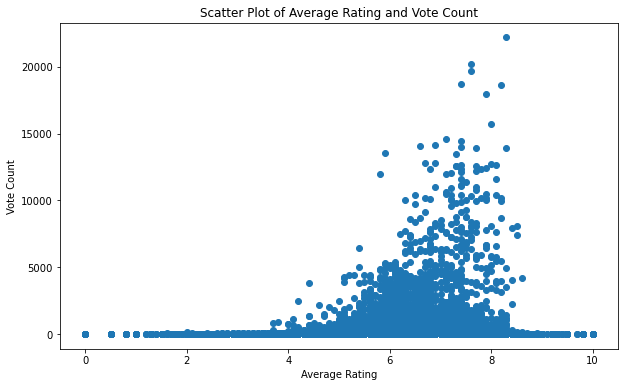

In [15]:
# Scatter plot of average rating in tmdb_movies
plt.figure(figsize=(10, 6))
plt.scatter(tmdb_movies['vote_average'], tmdb_movies['vote_count'])
plt.xlabel('Average Rating')
plt.ylabel('Vote Count')
plt.title('Scatter Plot of Average Rating and Vote Count')
plt.show()

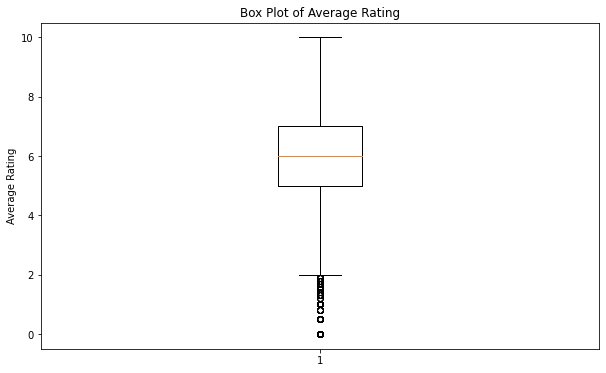

In [16]:
# Box plot of average rating in tmdb_movies
plt.figure(figsize=(10, 6))
plt.boxplot(tmdb_movies['vote_average'].dropna())
plt.ylabel('Average Rating')
plt.title('Box Plot of Average Rating')
plt.show()

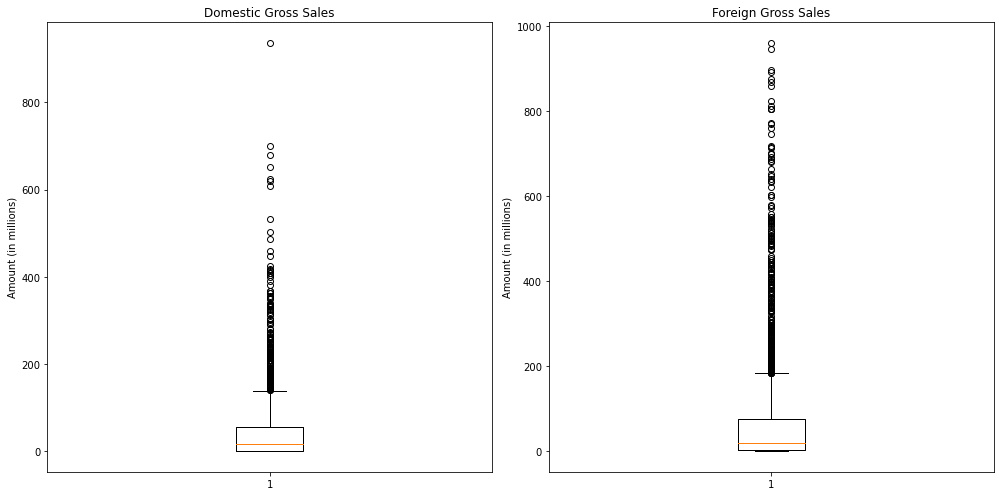

In [17]:
# Box plots of domestic and foreign gross sales in df
plt.figure(figsize=(14, 7))

# Subplot for domestic gross
plt.subplot(1, 2, 1)
plt.boxplot(movie_gross['domestic_gross'].dropna() / 1e6)  # Convert to millions for easier interpretation
plt.title('Domestic Gross Sales')
plt.ylabel('Amount (in millions)')

# Subplot for foreign gross
plt.subplot(1, 2, 2)
plt.boxplot(movie_gross['foreign_gross'].dropna() / 1e6)  # Convert to millions for easier interpretation
plt.title('Foreign Gross Sales')
plt.ylabel('Amount (in millions)')

plt.tight_layout()
plt.show()

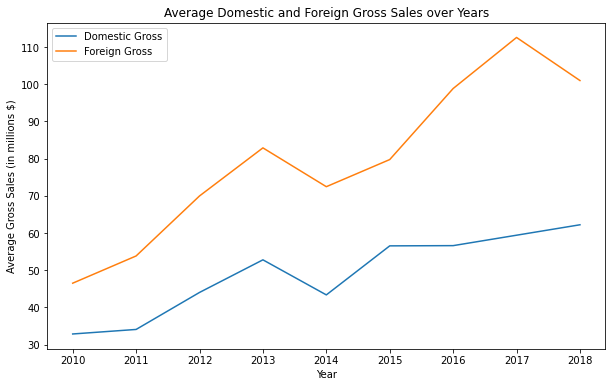

In [18]:
# Line graph of domestic and foreign gross sales in df
plt.figure(figsize=(10, 6))
plt.plot(movie_gross.groupby('year')['domestic_gross'].mean()/1e6, label='Domestic Gross')
plt.plot(movie_gross.groupby('year')['foreign_gross'].mean()/1e6, label='Foreign Gross')
plt.xlabel('Year')
plt.ylabel('Average Gross Sales (in millions $)')
plt.title('Average Domestic and Foreign Gross Sales over Years')
plt.legend()
plt.show()

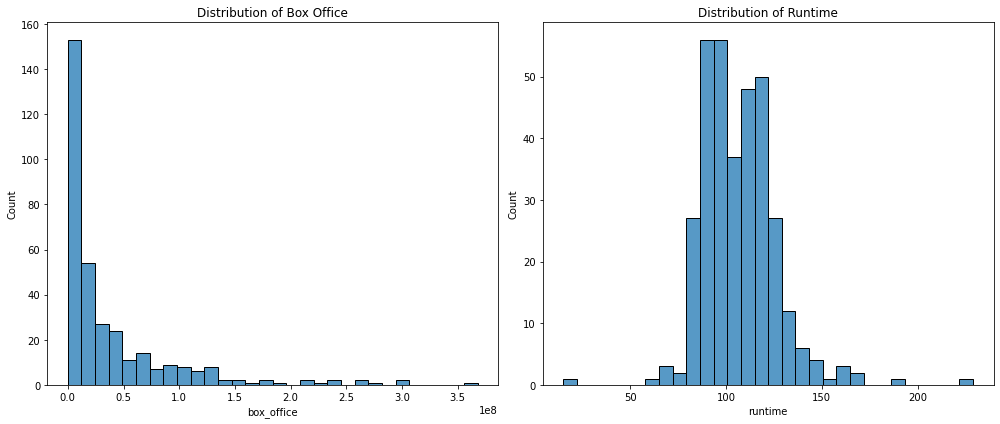

In [19]:
# Check the distribution of box_office and runtime
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(rt_movie['box_office'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of Box Office')

sns.histplot(rt_movie['runtime'], bins=30, ax=ax[1])
ax[1].set_title('Distribution of Runtime')

plt.tight_layout()
plt.show()

The histograms above represent the distributions of the box office revenue and runtime duration for the movies in our dataset.

1. **Distribution of Box Office**: Most of the movies in our dataset have box office revenue less than 0.5 billion. There are a few movies with box office revenue reaching up to 1 billion.

2. **Distribution of Runtime**: The majority of the movies in our dataset have a runtime between 80 and 120 minutes. There are a few movies that last more than 200 minutes.
***

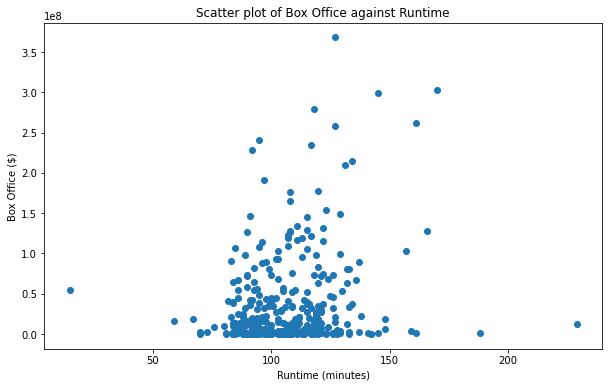

In [20]:
# Analyzing the relationship between runtime and box_office
plt.figure(figsize=(10, 6))
plt.scatter(rt_movie['runtime'], rt_movie['box_office'])
plt.title('Scatter plot of Box Office against Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Box Office ($)')
plt.show()

The scatter plot above shows the relationship between the runtime of movies and their box office revenue. There doesn't seem to be a clear correlation between the two variables. Movies with different runtimes have a wide range of box office revenues. There are movies with both low and high runtimes that have high box office revenues, suggesting that the length of a movie does not necessarily determine its financial success.
***

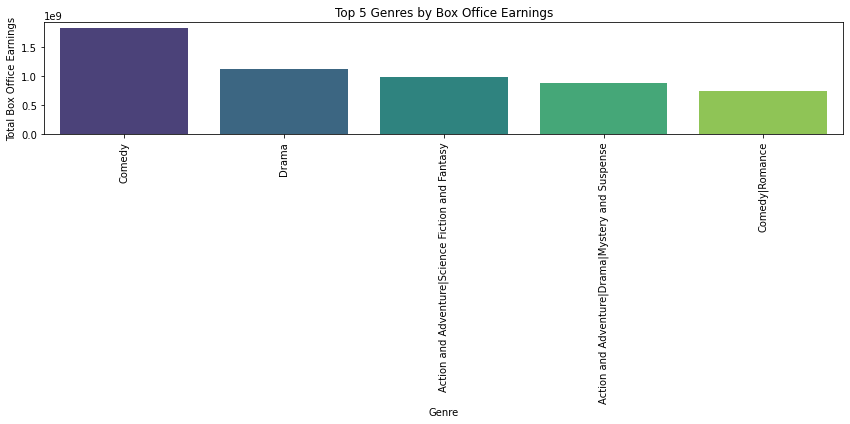

In [21]:
# Step 2: Explode the "genre" column to create a new row for each genre of a movie
rt_movie_exploded = rt_movie.explode('genre')

# Step 3: Group the data by genre and calculate the sum of box office earnings for each genre
genre_box_office = rt_movie_exploded.groupby('genre')['box_office'].sum().sort_values(ascending=False)

# Step 4: Select the top 5 genres
top_5_genres = genre_box_office.head(5)

# Step 5: Plot the top 5 genres with colors using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=top_5_genres.index, y=top_5_genres.values, palette='viridis')
plt.xlabel('Genre')
plt.ylabel('Total Box Office Earnings')
plt.title('Top 5 Genres by Box Office Earnings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

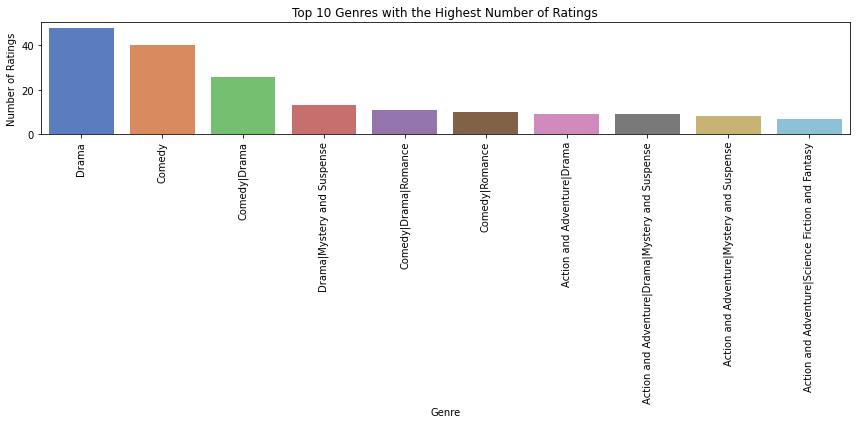

In [22]:
# Step 1: Group the data by genre and count the number of ratings for each genre
genre_ratings_count = rt_movie.groupby('genre')['rating'].count().sort_values(ascending=False)

# Step 2: Select the top 10 genres with the highest number of ratings
top_10_genres = genre_ratings_count.head(10)

# Step 3: Plot the top 10 genres with colors using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='muted')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Genres with the Highest Number of Ratings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


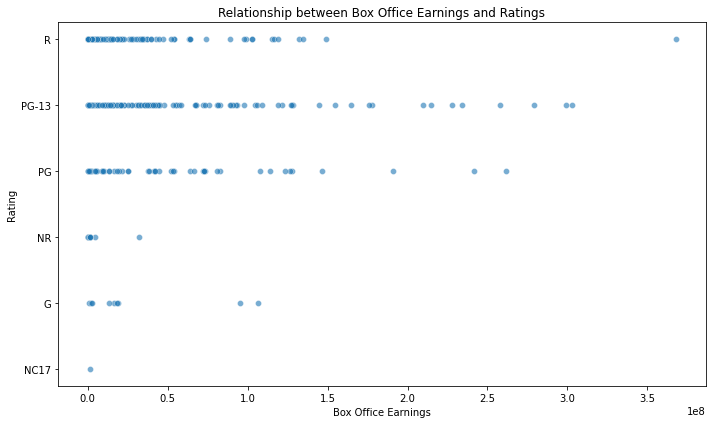

In [23]:
# Step 2: Create a scatter plot to visualize the relationship between box office earnings and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='box_office', y='rating', data=rt_movie, alpha=0.6)
plt.xlabel('Box Office Earnings')
plt.ylabel('Rating')
plt.title('Relationship between Box Office Earnings and Ratings')
plt.tight_layout()
plt.show()

### Evaluation
Based on the analysis conducted, we can draw the following conclusions:

***Top 10 Profitable Movie Genres:*** This bar chart shows the top 10 profitable movie genres based on total domestic gross revenue. It appears that Action, Adventure, and Comedy are the most profitable genres.

Average Domestic Gross Revenue by Release Month: This line chart shows the average domestic gross revenue for movies released in each month. It appears that movies released in May, June, and July tend to have higher domestic gross revenues.

Average ROI by Budget Range: This bar chart shows the average return on investment (ROI) for different budget ranges. 
***

### Conclusions

Based on the analysis, here are the key recommendations for Microsoft as they venture into the movie industry:

Focus on Profitable Genres: Microsoft should consider focusing on producing movies in genres that have proven to be most profitable, namely Action, Adventure, Comedy, Drama, and Science Fiction. These genres have demonstrated high grossing potential and are popular among audiences.

Optimize Release Timing: The timing of a movie's release plays a critical role in its box office success. Our analysis suggests that movies released in the summer months (May, June, July) tend to generate higher revenues. Microsoft should strategically plan the release dates of its movies to coincide with these months to maximize audience reach and box office revenues.

Strategic Budget Allocation: Our analysis of budget and return on investment (ROI) suggests that movies with a budget of less than $1M tend to have the highest average ROI. However, the gross revenue for these films tends to be lower due to their smaller scale. Therefore, Microsoft should balance its budget allocation by investing in both low and high budget films. High budget films, while having a slightly lower ROI, could potentially generate more revenue and bring more visibility and prestige to Microsoft's new movie studio.

Further Research and Analysis: This analysis provides a good starting point, but Microsoft should continue to conduct more detailed and specific research. For instance, understanding the influence of directors and actors, the effect of movie ratings and reviews, and the role of marketing and distribution strategies could provide more nuanced insights for decision-making. Utilizing machine learning techniques could also be beneficial in predicting the success of a movie based on various features.

Regular Updates: The movie industry is dynamic and audience preferences can change over time. Microsoft should ensure that the analysis is updated regularly as new data becomes available, to keep the recommendations current and relevant.

By following these recommendations, Microsoft can make informed decisions that increase the chances of success for its new venture into the movie industry.
***

In [24]:
print('end')

end
